In [1]:
# default_exp world

# Perlin Noise for World Generation

Based on the tutorial that can be found [here](https://medium.com/@yvanscher/playing-with-perlin-noise-generating-realistic-archipelagos-b59f004d8401)

<br>

### Imports

In [198]:
import pandas as pd
import numpy as np

import noise
from random import randrange, randint, choice

import seaborn as sns
import matplotlib.pyplot as plt

import os
from ipypb import track
import FEAutils as hlp

<br>

### Perlin Noise Base

We'll start by creating a base world that contains perlin noise

In [145]:
#exports
def generate_world(shape=(1024, 1024), scale=100.0, octaves=6, persistence=0.5, lacunarity=2, base=None):
    world = np.zeros(shape)
    
    if base is None:
        base = randrange(100)

    for i in track(range(shape[0]), label='generating'):
        for j in range(shape[1]):
            world[i, j] = noise.pnoise2(i/scale, 
                                        j/scale, 
                                        octaves=octaves, 
                                        persistence=persistence, 
                                        lacunarity=lacunarity, 
                                        repeatx=shape[0], 
                                        repeaty=shape[1], 
                                        base=base) + 0.5 # we want between 0 - 1, not -0.5 - 0.5
            
    return world

     generating [█████████████████████████████████████████████] 1024/1024 [00:02<00:00, 0.00s/it]

Wall time: 2.53 s


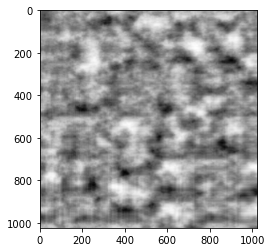

In [4]:
%%time

world = generate_world()
        
plt.imshow(world, cmap='Greys')

<br>

We can explore how changing the octave and lacunarity levels influence the output

     octaves: 1 [█████████████████████████████████████████████] 3/3 [00:07<00:03, 2.31s/it]

     generating [█████████████████████████████████████████████] 1024/1024 [00:02<00:00, 0.00s/it]

     generating [█████████████████████████████████████████████] 1024/1024 [00:02<00:00, 0.00s/it]

     generating [█████████████████████████████████████████████] 1024/1024 [00:03<00:00, 0.00s/it]

     octaves: 2 [█████████████████████████████████████████████] 3/3 [00:07<00:03, 2.50s/it]

     generating [█████████████████████████████████████████████] 1024/1024 [00:03<00:00, 0.00s/it]

     generating [█████████████████████████████████████████████] 1024/1024 [00:02<00:00, 0.00s/it]

     generating [█████████████████████████████████████████████] 1024/1024 [00:03<00:00, 0.00s/it]

     octaves: 4 [█████████████████████████████████████████████] 3/3 [00:07<00:02, 2.48s/it]

     generating [█████████████████████████████████████████████] 1024/1024 [00:02<00:00, 0.00s/it]

     generating [█████████████████████████████████████████████] 1024/1024 [00:02<00:00, 0.00s/it]

     generating [█████████████████████████████████████████████] 1024/1024 [00:02<00:00, 0.00s/it]

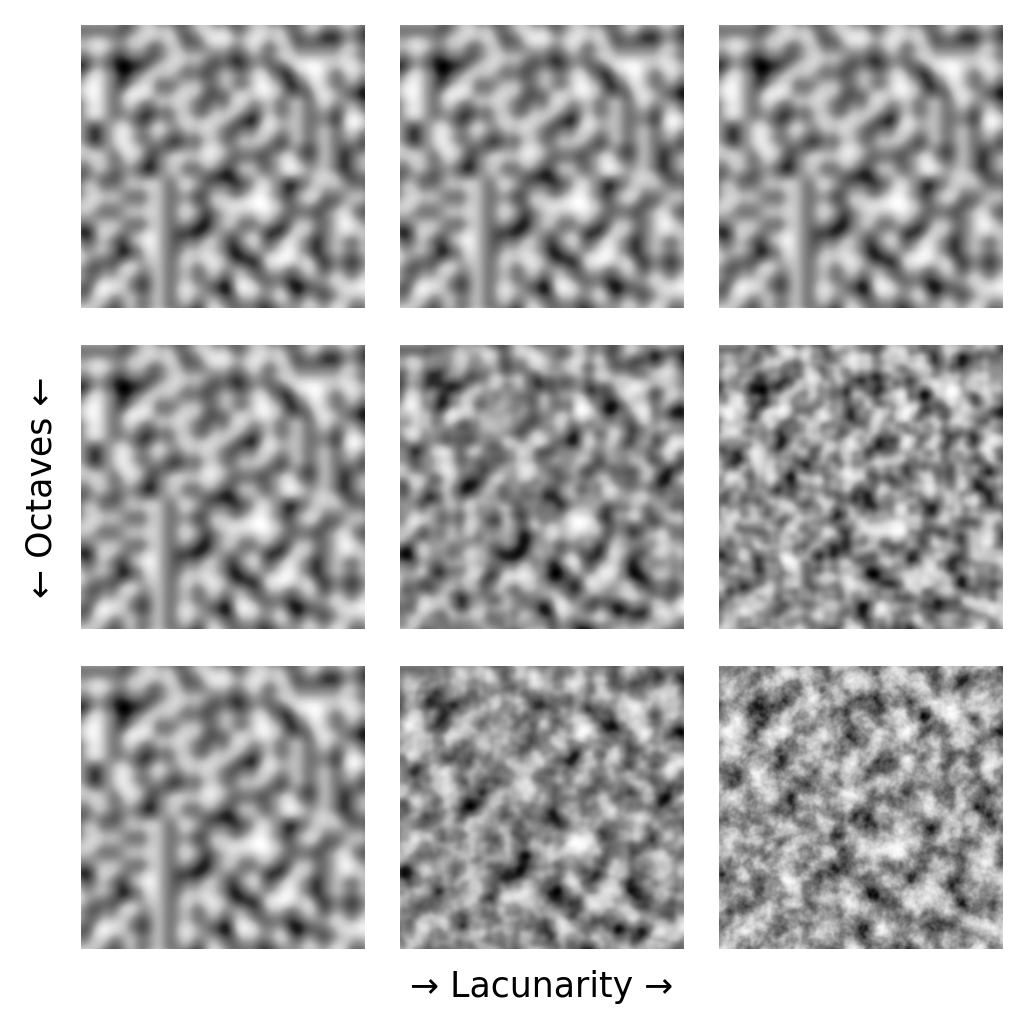

In [5]:
octaves_set = [1, 2, 4]
lacunarity_set = [1, 1.5, 2]

fig, axs = plt.subplots(dpi=250, figsize=(4, 4), nrows=len(octaves_set), ncols=len(lacunarity_set))
axs = axs.flatten()

ax_idx = 0

for octaves in octaves_set:
    for lacunarity in track(lacunarity_set, label=f'octaves: {octaves}'):
        ax = axs[ax_idx]
        world = generate_world(octaves=octaves, lacunarity=lacunarity, base=0)
        
        ax.imshow(world, cmap='Greys')
        
        ax.set_xticks([])
        ax.set_yticks([])
        hlp.hide_spines(ax, positions=['top', 'bottom', 'left', 'right'])
        
        ax_idx += 1
        
fig.text(0.5, 0, '→ Lacunarity →', ha='center', va='center')
fig.text(0, 0.5, '← Octaves ←', ha='center', va='center', rotation='vertical')
fig.tight_layout()

<br>

### Differentiating Terrian

In [6]:
def add_color(world, elevation_max_to_terrain_colour):
    color_world = np.zeros(world.shape+(3,))
    
    for i in track(range(world.shape[0]), label='colouring'):
        for j in range(world.shape[1]):
            elevation = world[i, j]
            
            for elevation_max, terrain_colour in elevation_max_to_terrain_colour.items():
                if elevation_max > elevation:
                    color_world[i, j] = terrain_colour
                    break

    return color_world

     generating [█████████████████████████████████████████████] 1024/1024 [00:03<00:00, 0.00s/it]

      colouring [█████████████████████████████████████████████] 1024/1024 [00:04<00:00, 0.00s/it]

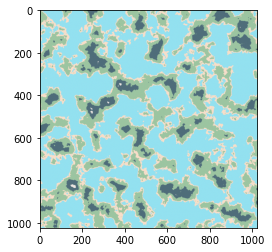

In [176]:
# https://coolors.co/93e1f0-f9dec9-9cc5a1-4f6d7a-ede7e3 <- currently storing them here

elevation_max_to_terrain_colour = { 
    0.5: (147/255, 225/255, 240/255), # water
    0.55: (249/255, 222/255, 201/255), # beach
    0.7: (156/255, 197/255, 161/255), # grass
    0.9: (79/255, 109/255, 122/255), # mountain
    1: (237/255, 231/255, 227/255), # snow
}

world = generate_world(base=10)
color_world = add_color(world, elevation_max_to_terrain_colour)

plt.imshow(color_world)

<br>

### Perlin's Planet

In [180]:
#exports
def get_dist_to_coords(world, x_coord=None, y_coord=None):
    width, height = world.shape[0], world.shape[1]
    
    if x_coord is None:
        x_coord = width/2
        
    if y_coord is None:
        y_coord = height/2

    X_dist, Y_dist = np.meshgrid(
        np.linspace(0, width, width),
        np.linspace(0, height, height)
    )
    
    X_dist = np.abs(X_dist - x_coord)
    Y_dist = np.abs(Y_dist - y_coord)
    
    dist = np.sqrt(X_dist**2 + Y_dist**2)
    
    return dist

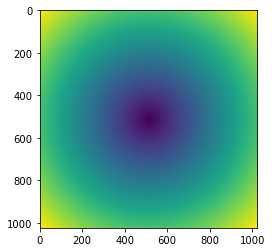

In [181]:
dist = get_dist_to_coords(world)

plt.imshow(dist)

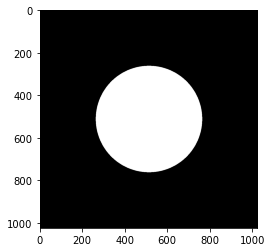

In [182]:
r = 250

mask = (dist >= r)

plt.imshow(mask, cmap='Greys')

In [183]:
#exports
def add_color_mask(color_world, mask_colour=(0, 0, 0)):
    for i in track(range(color_world.shape[0]), label='masking'):
        for j in range(color_world.shape[1]):
            if mask[i, j] == True:
                color_world[i, j] = mask_colour
                
    return color_world

        masking [█████████████████████████████████████████████] 1024/1024 [00:05<00:00, 0.00s/it]

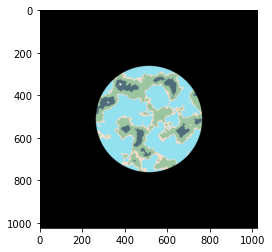

In [184]:
perlin_planet = add_color_mask(color_world.copy())
            
plt.imshow(perlin_planet)

In [185]:
#exports
def get_coord_dist_weights(world, x_coord=None, y_coord=None):
    weight = get_dist_to_coords(world, x_coord=x_coord, y_coord=y_coord)
    weight = 1 - weight/weight.max()
    
    return weight

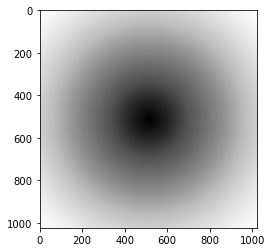

In [186]:
weight = get_coord_dist_weights(world)

plt.imshow(weight, cmap='Greys')

In [187]:
#exports
def weight_world(world, coords=[(None, None)], weight_adj_func=lambda weight: weight):
    weight = np.zeros(world.shape)
    
    for x_coord, y_coord in coords:
        weight += weight_adj_func(get_coord_dist_weights(world, x_coord=x_coord, y_coord=y_coord))
    
    weighted_world = np.multiply(world, weight)
    weighted_world = weighted_world/weighted_world.max()
    
    return weighted_world

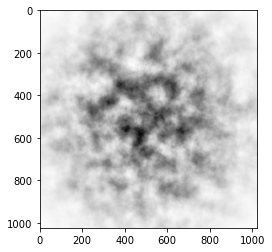

In [188]:
weighted_world = weight_world(world)
        
plt.imshow(weighted_world, cmap='Greys')

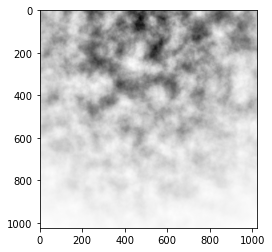

In [189]:
weighted_world = weight_world(world, [(512, 0)])
        
plt.imshow(weighted_world, cmap='Greys')

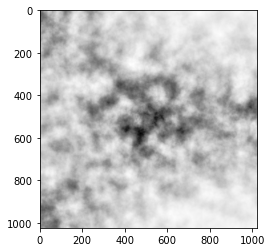

In [190]:
coords = [(0, 0), (1024, 512), (512, 512), (0, 1024)]
weight_adj_func = lambda weight: weight**3

weighted_world = weight_world(world, coords, weight_adj_func)
        
plt.imshow(weighted_world, cmap='Greys')

      colouring [█████████████████████████████████████████████] 1024/1024 [00:04<00:00, 0.00s/it]

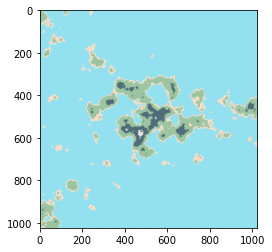

In [191]:
weighted_colour_world = add_color(weighted_world, elevation_max_to_terrain_colour)

plt.imshow(weighted_colour_world)

In [20]:
#exports
def generate_weighted_coloured_world(elevation_max_to_terrain_colour, coords=[(None, None)], weight_adj_func=lambda weight: weight, **world_gen_kwargs):
    world = generate_world(**world_gen_kwargs)
    weighted_world = weight_world(world, coords=coords, weight_adj_func=weight_adj_func)
    weighted_colour_world = add_color(weighted_world, elevation_max_to_terrain_colour)
    
    return weighted_colour_world

In [177]:
%%time

weighted_colour_world = generate_weighted_coloured_world(
    elevation_max_to_terrain_colour, 
    coords=
   [(x[0]*2, x[1]*2) for x in [(1451.5071921199556, 2001.48132543295),
    (1958.0863777486618, 1875.2284482438058),
    (173.7309019670969, 607.4084533974573),
    (157.9746550461917, 1903.8210569059006),
    (2016.9683902731153, 29.693113788542178),
    (1929.6293457778906, 375.7420226006112),
    (1437.2701630112124, 483.0427165742847),
    (383.13808741672415, 606.0798066790929),
    (687.7251012954154, 96.98636085995993),
    (1509.2018891786802, 1014.5013613770284)]],
    weight_adj_func=lambda weight: weight**2.5, 
    base=42, 
    scale=200*2,
    lacunarity=1.5,
    shape=(2048*2, 2048*2)
)

     generating [█████████████████████████████████████████████] 4096/4096 [00:47<00:00, 0.01s/it]

      colouring [█████████████████████████████████████████████] 4096/4096 [01:03<00:00, 0.02s/it]

Wall time: 2min 3s


In [178]:
#exports
def clean_plot(world, ax=None):
    if ax is None:
        fig, ax = plt.subplots(dpi=500)
    else:
        fig = plt.gcf()

    ax.imshow(world)

    ax.set_xticks([])
    ax.set_yticks([])
    hlp.hide_spines(ax, positions=['top', 'bottom', 'left', 'right'])

    return fig, ax

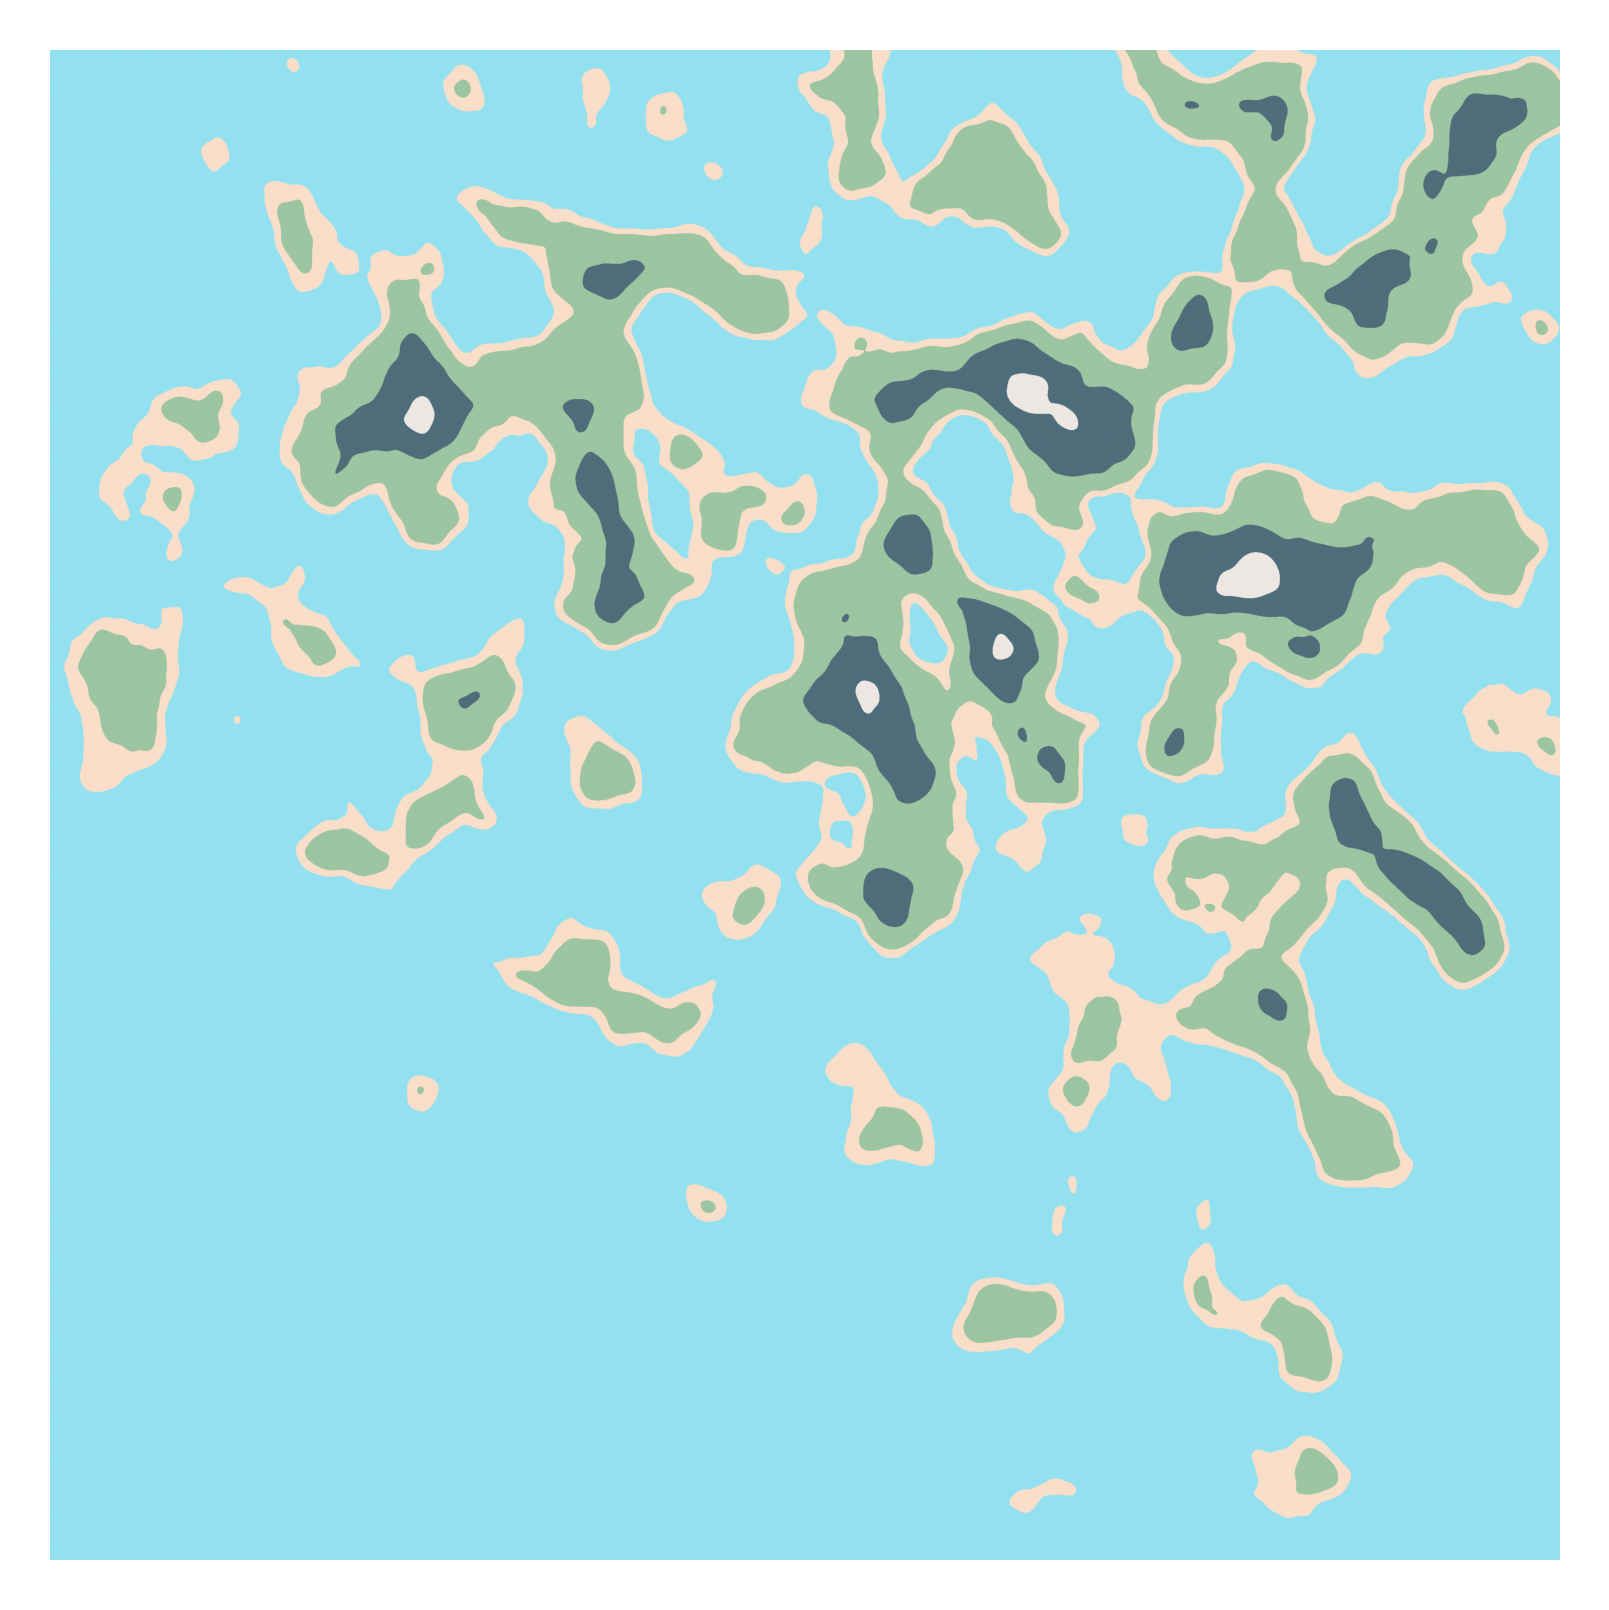

In [179]:
fig, ax = clean_plot(weighted_colour_world)

In [57]:
#exports
def gen_random_vals(loc=0, scale=1, size=1, exponent=1, edge_weighted=True): 
    random_vals = np.random.normal(loc=loc, scale=scale, size=99999)
    val_directions = ((random_vals>0)-0.5)*2
    random_vals = random_vals**exponent
    
    if exponent%2 == 0:
        random_vals = np.multiply(random_vals, val_directions)
    
    random_vals = random_vals/np.abs(random_vals).max()
    
    if edge_weighted == True:
        random_vals = np.hstack((random_vals[random_vals>0], 1+random_vals[random_vals<0]))
    else:
        random_vals += 0.5
        
    random_vals = np.random.choice(random_vals, size=size)
    
    return random_vals

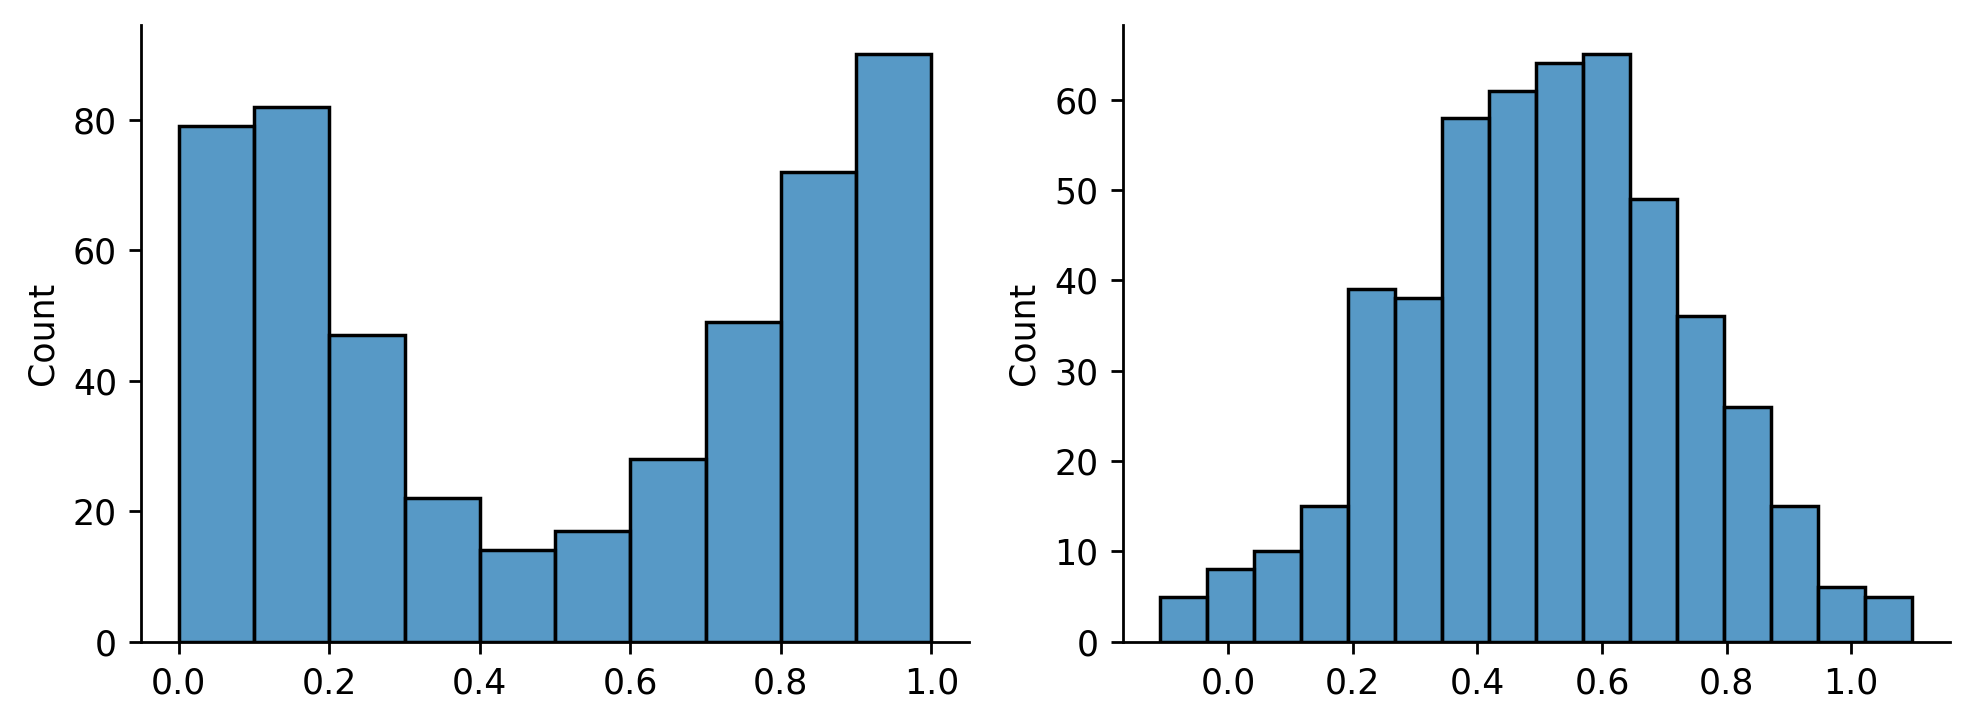

In [60]:
fig, axs = plt.subplots(dpi=250, ncols=2, figsize=(8, 3))

sns.histplot(gen_random_vals(size=500, edge_weighted=True), ax=axs[0])
sns.histplot(gen_random_vals(size=500, edge_weighted=False), ax=axs[1])

for ax in axs:
    hlp.hide_spines(ax)
    
fig.tight_layout()

In [36]:
#exports
def generate_random_coords(num_coords=5, width=1024, height=1024, **rand_coord_kwargs):
    coords = []
    
    for _ in range(num_coords):
        coords += [(
            gen_random_vals(**rand_coord_kwargs)[0]*width, 
            gen_random_vals(**rand_coord_kwargs)[0]*height
        )]
        
    return coords

In [37]:
coords = generate_random_coords(num_coords=5, width=2048, height=2048)

coords

[(1560.7205575835792, 353.02428165561753),
 (992.0293610507749, 1112.9583619689226),
 (1323.935632394307, 1571.0949278916776),
 (136.74569862163293, 307.16032604909003),
 (233.0377592517424, 1214.7741081423405)]

<AxesSubplot:xlabel='0', ylabel='1'>

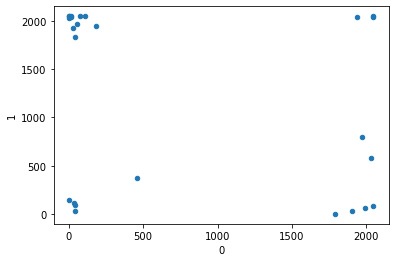

In [38]:
coords = generate_random_coords(num_coords=25, width=2048, height=2048, edge_weighted=True, exponent=2)

pd.DataFrame(coords).plot.scatter(0, 1)

In [206]:
#exports
def generate_island_world(island_type_params):
    coords = generate_random_coords(num_coords=island_type_params['num_coords'], width=2048, height=2048, edge_weighted=island_type_params['edge_weighted'], exponent=1)

    weighted_colour_world = generate_weighted_coloured_world(
        elevation_max_to_terrain_colour, 
        coords=coords,
        weight_adj_func=lambda weight: weight**island_type_params['weight_exp'], 
        scale=island_type_params['scale'],
        octaves=island_type_params['octaves'],
        lacunarity=1.5,
        shape=(2048, 2048)
    )
    
    return weighted_colour_world

In [210]:
island_types = {
    'big': {
        'num_coords': 10,
        'octaves': 50,
        'edge_weighted': False,
        'weight_exp': 5,
        'scale': 300
    },
    'simple': {
        'num_coords': 15,
        'octaves': 1,
        'edge_weighted': False,
        'weight_exp': 2.5,
        'scale': 300
    },
    'ring': {
        'num_coords': 75,
        'octaves': 6,
        'edge_weighted': True,
        'weight_exp': 6.5,
        'scale': 200
    },
#     'dense': {
#         'num_coords': 10,
#         'octaves': 6,
#         'edge_weighted': True,
#         'weight_exp': 1,
#         'scale': 200
#     },
    'ridge': {
        'num_coords': 10,
        'octaves': 6,
        'edge_weighted': True,
        'weight_exp': 2.5,
        'scale': 200
    },
}

# should cache the worlds inside .npz files

visualise_island_types = False

if visualise_island_types == True:
    for island_type_name, island_type_params in track(island_types.items()):
        weighted_colour_world = generate_island_world(island_type_params)

        fig, ax = plt.subplots(dpi=150)
        clean_plot(weighted_colour_world, ax=ax)
        ax.set_title(f'Island Type: {island_type}')

In [211]:
#exports
def generate_islands_canvas_9(island_types, elevation_max_to_terrain_colour):
    fig, axs = plt.subplots(dpi=750, figsize=(4, 4), nrows=3, ncols=3)
    axs = axs.flatten()

    for ax_idx in track(range(len(axs))):
        island_type_name = choice(list(island_types.keys()))
        weighted_colour_world = generate_island_world(island_types, island_type_name)

        fig, ax = clean_plot(weighted_colour_world, ax=axs[ax_idx])
        
    return fig

In [ ]:
get_next_set_num = lambda island_dir: max([int(img.replace('9-set-', '').replace('.png', '')) for img in os.listdir(island_dir) if '9-set' in img])+1

generate_island_sets = True
island_dir = '../img/islands'

if generate_island_sets == True:
    for _ in range(10):
        next_set_num = get_next_set_num(island_dir)
        fig = generate_islands_canvas_9(island_types, elevation_max_to_terrain_colour)
        fig.savefig(f'{island_dir}/9-set-{next_set_num}.png', dpi=750)

 [############################################################] 0/9 [0<0, 0.00s/it]

     generating [█████████████████████████████████████████████] 2048/2048 [00:12<00:00, 0.01s/it]

      colouring [██████████████████████#######################] 1002/2048 [00:11<00:00, 0.01s/it]

In [ ]:
weighted_colour_world = generate_weighted_coloured_world(
    elevation_max_to_terrain_colour, 
    coords=
   [(x[0]*2, x[1]*2) for x in [(1451.5071921199556, 2001.48132543295),
    (1958.0863777486618, 1875.2284482438058),
    (173.7309019670969, 607.4084533974573),
    (157.9746550461917, 1903.8210569059006),
    (2016.9683902731153, 29.693113788542178),
    (1929.6293457778906, 375.7420226006112),
    (1437.2701630112124, 483.0427165742847),
    (383.13808741672415, 606.0798066790929),
    (687.7251012954154, 96.98636085995993),
    (1509.2018891786802, 1014.5013613770284)]],
    weight_adj_func=lambda weight: weight**2.5, 
    base=42, 
    scale=200*2,
    lacunarity=1.5,
    shape=(2048*2, 2048*2)
)

fig, ax = big_plot(weighted_colour_world)

In [ ]:
# could use perlin noise to select the random points
# could try to do that in 3d and then have it change over time
# should speed up colour generation using numpy to apply across the whole matrix
# should look into implementing this within pycanvas?
# then could try to hook up to a voila front-end
# could make it possible to use svg icons to help auto gen the islands
# is there a vectorised version of noise?
# should also look at the actual DEM underneath and see if there's a nice way to smooth it
# is there a nice way to map the image onto a sphere using standard reprojection libraries or pure numpy?

In [22]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-svg-helpers.ipynb.
Converted 02-solar-system.ipynb.
Converted 03-scenery-dither.ipynb.
Converted 04-reflect.ipynb.
Converted 05-cellular-automata.ipynb.
Converted 06-perlin-noise.ipynb.
